In [1]:
# ipython magic functions for automatic reloading coda changes in .py files
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import plotting_utils as plt_utils
from save_scores import convert_to_percentiles
import ConvLSTM_PyTorch_master.utils as utils
import pickle

data_root     = '../../../../../../mnt/data/scheepensd94dm/data/' # set manually to data root 
models_root   = '../../../../../../mnt/data/scheepensd94dm/saved_models/' # set manually to model root 
plots_root    = './plots/'
examples_root = './example_forecasts/'
scores_root   = './saved_scores/'

class args():
    def __init__(self):
        self.frames_predict=12
        self.batch_size=16
        self.hpa=1000
        self.num_years=40
args = args()

save_plots=True

if not save_plots: 
    save_as=None 

# 2 Methodology
## 2.1 Data Collection and Preprocessing 

In [154]:
data = np.load(os.path.join(data_root,'adaptor.mars.internal-Horizontal_velocity_%s.npy'%args.hpa))[24*365*32:24*365*40] # 8 years

print('data shape:',data.shape)
print(data.min(), data.max())

data shape: (70080, 64, 64)
0.0001556097263669673 30.4589710191613


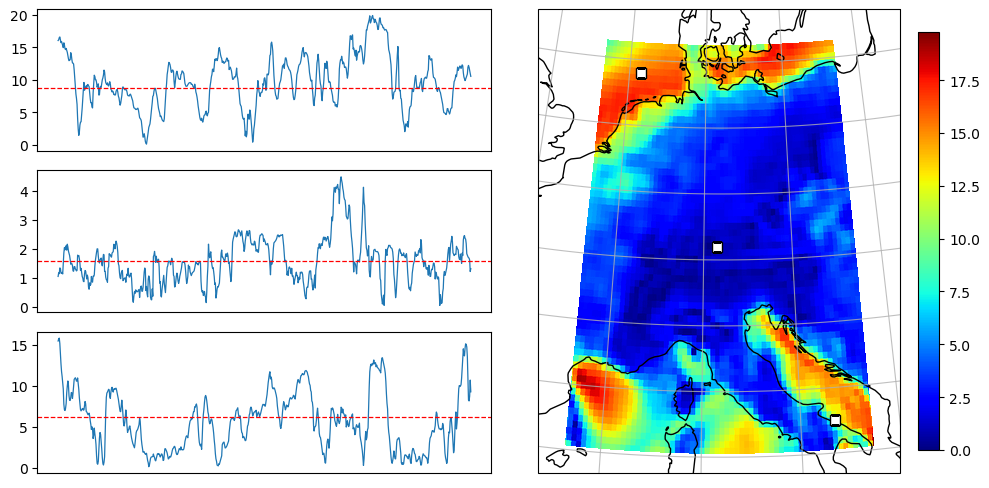

In [155]:
# Figure 1 
if save_plots: 
    save_as=os.path.join(plots_root,'data_example_frame.pdf')
    
plt_utils.plot_example_frame(data, 0, save_as)

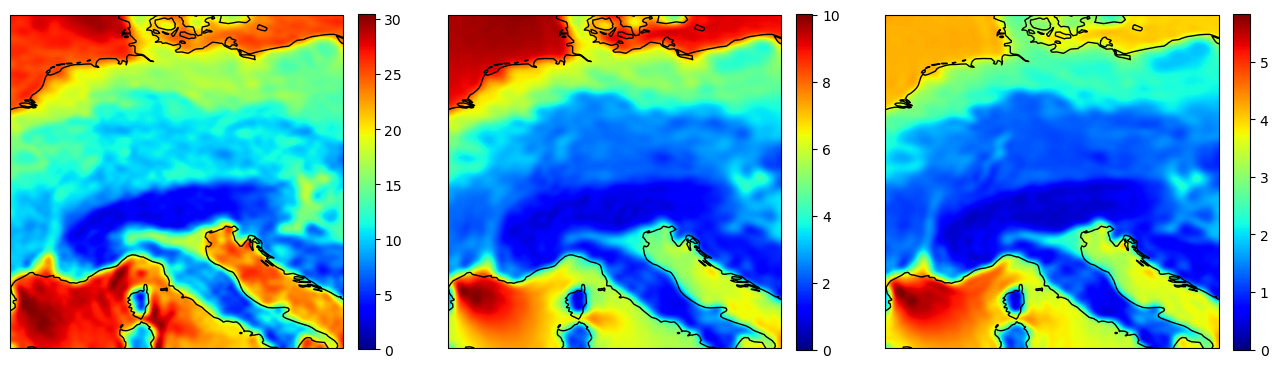

In [156]:
# Figure 2 
if save_plots: 
    save_as=os.path.join(plots_root,'data_maps_raw.pdf')
    
plt_utils.plot_maps(data, save_as)

In [157]:
del data 

### 2.2.1 Inversely Weighted Loss  

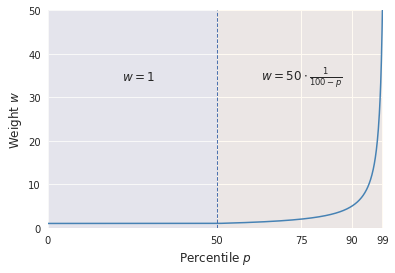

In [3]:
# Figure 4
if save_plots: 
    save_as=os.path.join(plots_root,'weight_function.pdf')
    
plt_utils.plot_weight_function(save_as)

### 2.2.2 Squared Error-Relevance Area Loss 

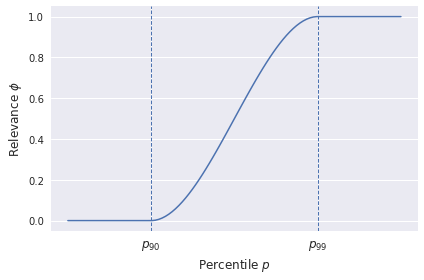

In [4]:
# Figure 5 
if save_plots:
    save_as=os.path.join(plots_root,'relevance_function.pdf')
    
plt_utils.plot_relevance_function(save_as)

# 3 Results 

In [5]:
for model in ['wmae_5_1000_40years',
              'wmse_5_1000_40years',
              'sera_5_1000_40years',
              'mae_4_1000_40years',
              'mse_5_1000_40years',
              'persistence',
              'ensemble']:
    
    scores_scales = np.load(os.path.join(scores_root,'%s/scores_scales.p'%model),allow_pickle=True)
    print(np.round(scores_scales['bias'][:,0],3))
    #print(np.round(scores_scales['rmse'],3))

[1.042 1.136 1.211 1.236 1.019 0.398]
[1.115 1.242 1.366 1.402 1.036 0.294]
[1.08  1.434 2.491 3.485 1.664 0.348]
[0.971 0.921 0.84  0.773 0.577 0.307]
[0.967 0.916 0.842 0.785 0.595 0.292]
[1.015 1.027 1.042 1.053 1.055 1.049]
[1.096 1.299 1.642 1.665 1.025 0.296]


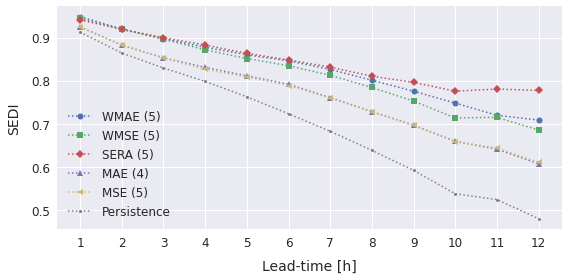

In [56]:
# Figure 6
if save_plots:
    save_as=os.path.join(plots_root,'model_comparison_times.pdf')
    
plt_utils.plot_model_comparison_times(scores_root, save_as)

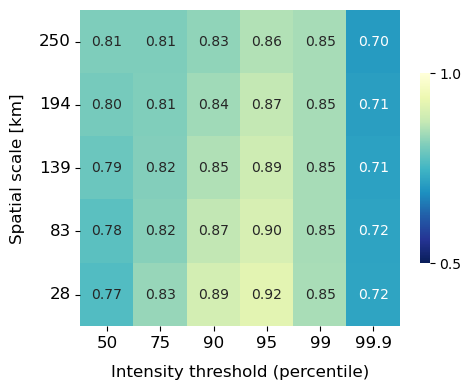

In [144]:
# Figure 7
if save_plots:
    save_as=os.path.join(plots_root,'intensity_scale_diagram.pdf')
    
model = 'sera_5_1000_40years'

plt_utils.plot_intensity_scale_diagram(scores_root, model, save_as)

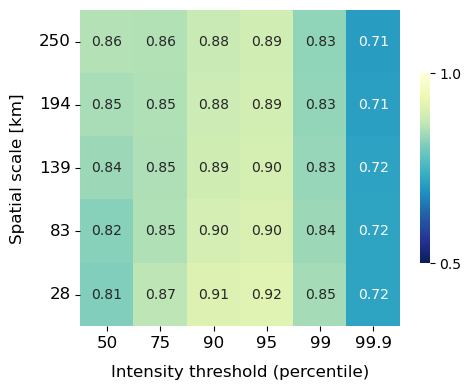

In [145]:
# Figure 10
if save_plots:
    save_as=os.path.join(plots_root,'intensity_scale_diagram_ensemble.pdf')
    
model = 'ensemble'

plt_utils.plot_intensity_scale_diagram(scores_root, model, save_as)

### Example Forecasts (Figures 8 & 9)

In [74]:
import torch 
import datetime 

from ConvLSTM_PyTorch_master.encoder import Encoder
from ConvLSTM_PyTorch_master.decoder import Decoder
from ConvLSTM_PyTorch_master.model import ED
from ConvLSTM_PyTorch_master.net_params import convlstm_encoder_params, convlstm_decoder_params, convgru_encoder_params, convgru_decoder_params
from ConvLSTM_PyTorch_master.data_loader import load_era5
import ConvLSTM_PyTorch_master.utils as utils 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Use device: ", device)

Use device:  cuda:0


In [75]:
def load_model(args):
    
    STAMP = "%s_%s_1000_40years"%(args.loss, args.num_layers)
    save_dir = os.path.join(models_root, STAMP)

    encoder_params = convlstm_encoder_params(args.num_layers, args.frames_predict)
    decoder_params = convlstm_decoder_params(args.num_layers, args.frames_predict)

    encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
    decoder = Decoder(decoder_params[0], decoder_params[1], args.num_layers).cuda()
    net = ED(encoder, decoder)

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    # load model
    print('==> loading existing model')
    model_info = torch.load(os.path.join(save_dir, 'checkpoint.pth.tar'))
    net.load_state_dict(model_info['state_dict'])
    net.eval()
    print('Done.')
    return net 

In [76]:
nets = []
for loss, n in [['wmae',5],['wmse',5],['sera',5],['mae',4],['mse',5]]:
    args.loss = loss
    args.num_layers = n
    net = load_model(args)
    nets.append(net)

==> loading existing model
Done.
==> loading existing model
Done.
==> loading existing model
Done.
==> loading existing model
Done.
==> loading existing model
Done.


In [94]:
class Ensemble:
    def __init__(self, nets):
        self.nets = nets
        
    def predict(self, inputs, device): 
        preds = []
        for net in self.nets:
            pred = net(inputs.unsqueeze(2).to(device)).squeeze().detach().cpu().numpy()
            preds.append(pred)
        return np.mean(np.array(preds),0) 

ensemble = Ensemble(nets[:3])

In [91]:
test_loader = load_era5(root=data_root, args=args, a=None, b=None, c=args.begin_testset, training=False)

number of years: 42.0


In [95]:
inputs, targets, preds = utils.predict_batchwise(test_loader, ensemble, device)
del test_loader, net 

In [102]:
inputs.shape, targets.shape, preds.shape

((1459, 12, 64, 64), (1459, 12, 64, 64), (1459, 12, 64, 64))

In [96]:
delta = 12
start_date = datetime.datetime(1979,1,1,0) + datetime.timedelta(days=365*args.begin_testset) # first testset date
dates = [start_date + datetime.timedelta(hours=delta+delta*i) for i in range(len(inputs))]

In [97]:
### selected forecasts: 
indices = [17, 23, 34, 38, 45, 49, 81, 97, 99, 101, 143, 153, 155, 158, 164, 169, 335, 367, 397, 461, 483, 556, 635, 670, 704, 709, 714, 861, 867, 870, 891, 1023, 1225, 1367]

In [ ]:
### visualising all models ... 

def single_prediction(net, inputs):
    inputs = inputs.unsqueeze(2).to(device)
    pred = net(inputs).squeeze().detach().cpu().numpy()
    return pred 

for t in indices:
    print(t)
    inputs_ = torch.FloatTensor(inputs[t]).unsqueeze(0)
    pred_list = []

    for net in nets: 
        pred = single_prediction(net, inputs_)
        pred_list.append(pred)

    ens = ensemble.predict(inputs_, device)
    pred_list.append(ens)


    vmin=-1
    vmax=4
    if save_plots: 
        save_as = os.path.join(examples_root, 'example_%s.pdf'%t)   
    plt_utils.plot_forecast_comparison(inputs[t], targets[t], pred_list, dates[t], t, vmin, vmax, save_as)

In [152]:
### visualising ensemble only ... 

vmin=-1
vmax=4

for t in indices:
    print(t)
    
#     if save_plots: 
#         save_as = os.path.join(examples_root, 'example_%s.pdf'%t)      
#         plt_utils.plot_forecast(inputs[t], targets[t], preds[t], dates[t], t, vmin, vmax, save_as=None)
    
    if save_plots: 
        save_as = os.path.join(examples_root, 'example_%s.mp4'%t) 
        plt_utils.save_animation(inputs[t], targets[t], preds[t], dates[t], vmin, vmax, save_as)

17
23
34
38
45
49
81
97
99
101
143
153
155
158
164
169
335
397
461
483
556
635
670
704
714
861
867
870
891
1023
1225
1367


# Appendices  

In [68]:
# rmse = plt_utils.forecasts_augmented(ensemble, inputs, targets, device)
# np.save(os.path.join(data_root,'rmse_array.npy'), rmse)

t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11


In [73]:
rmse = np.load(os.path.join(data_root,'rmse_array.npy'))

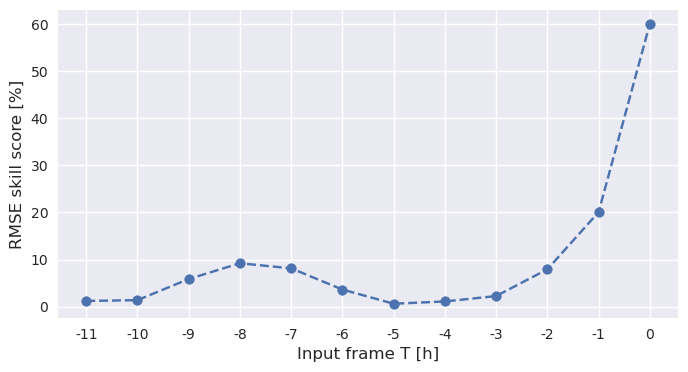

In [72]:
# Figure XXX
if save_plots:
    save_as = os.path.join(plots_root,'forecasts_augmented_rmse.pdf')
    
plt_utils.plot_score_over_leadtime(rmse, np.zeros(12), 'RMSE', save_as)